In [5]:
from nilearn import plotting as niplt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors
import pickle
import itertools
import glob
from collections import OrderedDict
import nibabel as nib
import matplotlib as ml
import mpld3
%load_ext autoreload
%autoreload 1
%aimport base.plotting

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [72]:
from base.classifiers import OnevsallClassifier, PairwiseClassifier
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("../data/datasets/abs_60topics_filt_jul.pkl")

In [73]:
sns.set_context('talk')

### Clustering solutions

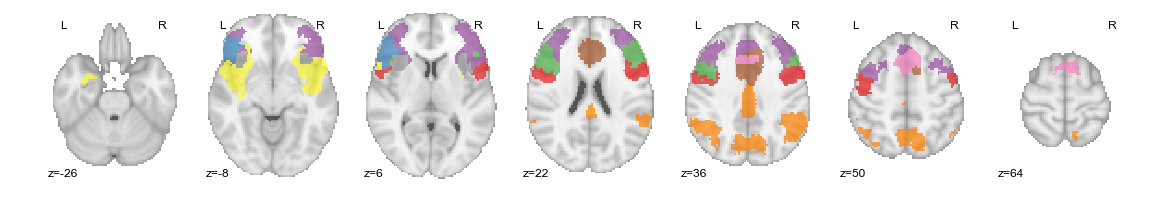

In [8]:
niplt.plot_roi('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k9.nii.gz',
               display_mode='z',
               cmap = mplcolors.ListedColormap(sns.color_palette('Set1', 9)),)

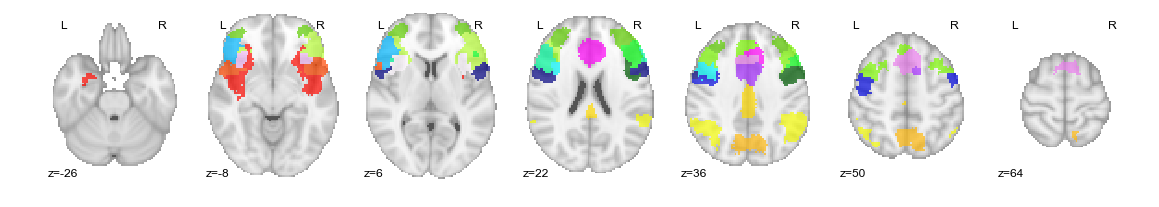

In [9]:
niplt.plot_roi('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k20.nii.gz',
               display_mode='z')

In [10]:
def plot_subset(nifti, layers, colors = None,  **kwargs):    
    nibs = nib.load(nifti)
    data = nibs.get_data()

    vmax = int(np.round(data.max()))
    
    for value in np.unique(np.round(data)):
        if np.in1d(value, layers)[0] == False:
            data[np.round(data) == value] = 0

    for i, value in enumerate(layers):
        data[np.round(data) == value] = i + 1

    niplt.plot_roi(nibs, cmap = mplcolors.ListedColormap(colors), draw_cross=False, **kwargs)

### Cluster labels

In [11]:
regions = zip(['preMotor', 'IFGo', 'IFS/IFJ', 'LPFC', 'PCC/Par', 'vcIns', 'dACC', 'preSMA', 'aIns'], range(1, 10))

core_regionsAll = OrderedDict(sorted(regions, key=lambda tup: tup[1]))

preMIFJ = ['preMotor', 'IFGo', 'IFS/IFJ']
LPFCPar = ['LPFC', 'PCC/Par']
CON = ['vcIns', 'dACC', 'preSMA', 'aIns']

core_colors = sns.color_palette('Set1', len(core_regionsAll.values()))

['preMotor', 'IFGo', 'IFS/IFJ', 'LPFC', 'PCC/Par', 'vcIns', 'dACC', 'preSMA', 'aIns']


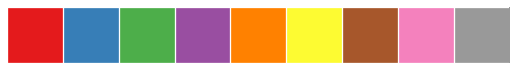

In [12]:
print core_regionsAll.keys()
sns.palplot(core_colors)

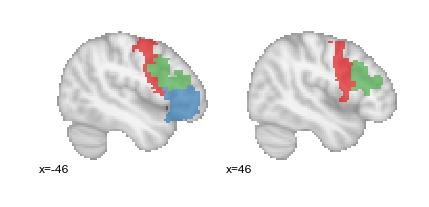

In [13]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in preMIFJ])

plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k9.nii.gz', mask, colors=colors, 
            display_mode='x', cut_coords=[-46, 46])


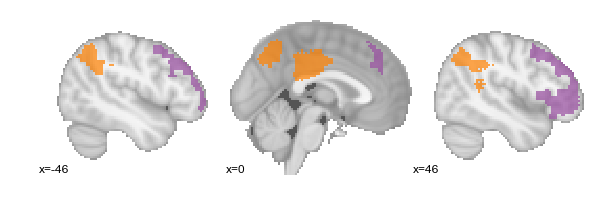

In [14]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in LPFCPar])

plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k9.nii.gz', mask, colors=colors, 
            display_mode='x', cut_coords=[-46, 0, 46])


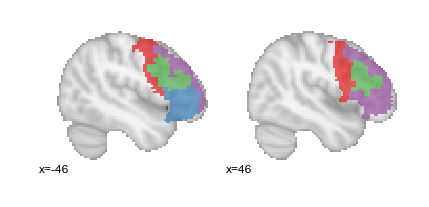

In [68]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems())])

plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k9.nii.gz', range(1,5), colors=colors[0:4], 
            display_mode='x', cut_coords=[-46, 46])


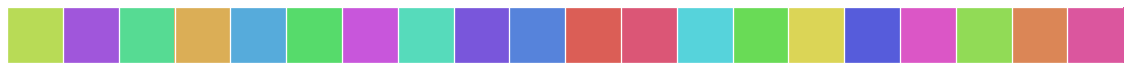

In [16]:
from random import shuffle
twenty = sns.color_palette("hls", 20)
shuffle(twenty)
sns.palplot(twenty)

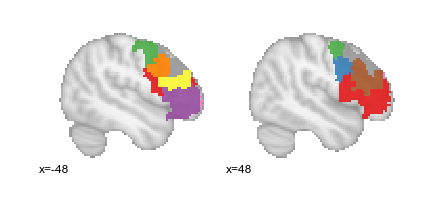

In [47]:
plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k20.nii.gz', range(1,11), alpha=0.9, 
            colors=sns.color_palette('Set1', 10),
            display_mode='x', cut_coords=[-48, 48])


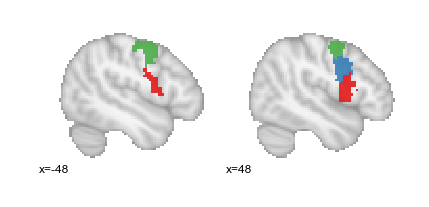

In [46]:
plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k20.nii.gz', range(1,4), alpha=0.9, 
            colors=sns.color_palette('Set1', 10)[0:3],
            display_mode='x', cut_coords=[-48, 48])


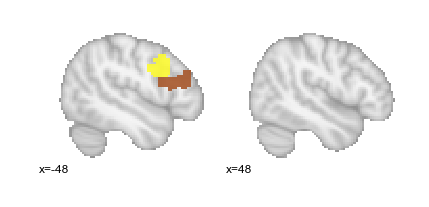

In [122]:
plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k20.nii.gz', range(5,7), alpha=0.9, 
            colors=sns.color_palette('Set1', 10)[5:7],
            display_mode='x', cut_coords=[-48, 48])


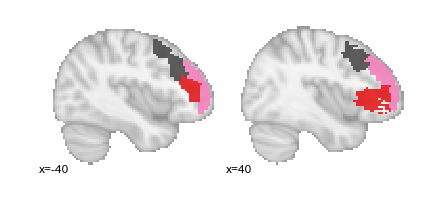

In [180]:
colors = (sns.color_palette('Set1', 10)[7], (.3, .3, .3), sns.color_palette('Set1', 10)[9])

plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k20.nii.gz', range(8,11), alpha=0.9, 
            colors=colors,
            display_mode='x', cut_coords=[-40, 40])


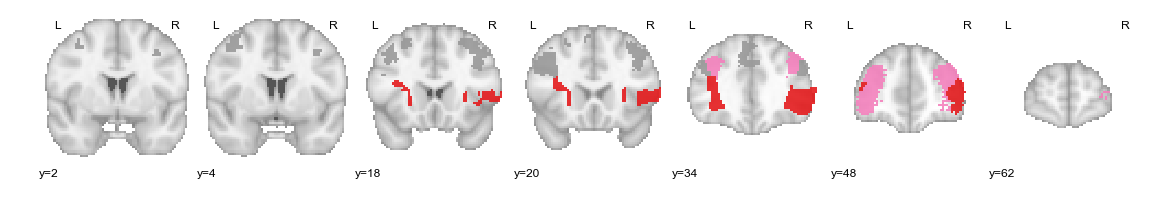

In [57]:
plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k20.nii.gz', range(8,11), alpha=0.9, 
            colors=sns.color_palette('Set1', 10)[7:],
            display_mode='y')

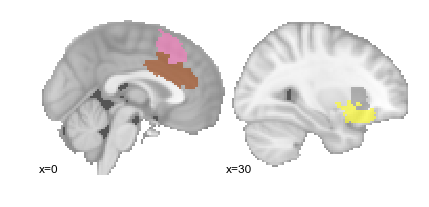

In [22]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in CON])

plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k9.nii.gz', mask, colors=colors, 
            display_mode='x', cut_coords=[0, 30])


## Classification Performance

In [76]:
clfs = [OnevsallClassifier.load(clf + "/classifier.pkl") for clf in glob.glob("../results/classification/FPN_hier*_GNB_t0.05_cog_topics_60/")]

In [77]:
all_scores = []
for clf in clfs:
    for n, score in enumerate(clf.class_score):
        all_scores.append([clf.mask_num, n + 1, clf.n_features_orig, 'clf' , score])
all_scores = pd.DataFrame(all_scores, columns=['n_regions', 'region', 'n_topics', 'clf', 'score'])

(0.5, 0.676)

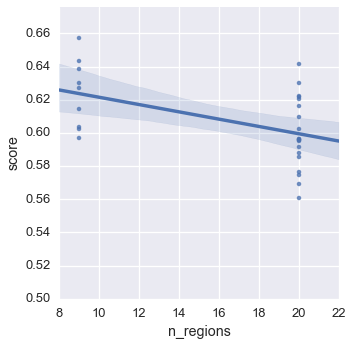

In [33]:
sns.lmplot('n_regions', 'score',  all_scores)
plt.ylim(0.5, 0.676)

## Functional specialization

### Preprocessing

In [160]:
num_regions = 20
n_topics = 60
o_clf = [clf for clf in clfs if (clf.mask_num == num_regions) & (clf.n_features_orig == n_topics)][0]

In [161]:
## Set up topic nicknames
word_keys = pd.read_csv("../data/unprocessed/abstract_topics_filtered/topic_sets/topic_keys" + str(n_topics) + "-july_cognitive.csv")
word_keys['topic_name'] = "topic" + word_keys['topic'].astype('str')

In [162]:
o_fi = pd.DataFrame(clf.odds_ratio)

# Melt feature importances, and add top_words for each feeature
o_fi['region'] = range(1, o_fi.shape[0] + 1)
o_fis_melt = pd.melt(o_fi, var_name='topic_order', value_name='importance', id_vars=['region'])

word_keys = pd.merge(pd.DataFrame(np.array([range(0, clf.feature_importances.shape[1]), clf.feature_names]).T, columns=['topic_order', 'topic_name']), word_keys)
word_keys.topic_order = word_keys.topic_order.astype('int')

o_fis_melt= pd.merge(o_fis_melt, word_keys)
o_fis_melt['abs_imp'] = np.abs(o_fis_melt['importance'])

In [163]:
def plot_clf_polar(clf, cmap=None, key='nickname', n_topics=60, n_top=3, labels=None, mask=None, selection='top', metric='correlation', max_val=None, return_labels=False):
    import pandas as pd
    import seaborn as sns
    from base.plotting import plot_polar

    ## Set up topic nicknames
    word_keys = pd.read_csv("../data/unprocessed/abstract_topics_filtered/topic_sets/topic_keys" + str(n_topics) + "-july_cognitive.csv")
    word_keys['topic_name'] = "topic" + word_keys['topic'].astype('str')

    o_fi = pd.DataFrame(clf.odds_ratio)

    # Melt feature importances, and add top_words for each feeature
    o_fi['region'] = range(1, o_fi.shape[0] + 1)
    o_fis_melt = pd.melt(o_fi, var_name='topic_order', value_name='importance', id_vars=['region'])

    word_keys = pd.merge(pd.DataFrame(np.array([range(0, clf.feature_importances.shape[1]), clf.feature_names]).T, columns=['topic_order', 'topic_name']), word_keys)
    word_keys.topic_order = word_keys.topic_order.astype('int')

    o_fis_melt= pd.merge(o_fis_melt, word_keys)
    o_fis_melt['abs_imp'] = np.abs(o_fis_melt['importance'])
    
    if mask is not None:
        o_fis_melt = o_fis_melt[o_fis_melt.region.isin(mask)]
    
    pplot = pd.pivot_table(o_fis_melt, values='importance', index=[key], columns=['region'])
    
    if cmap is None:
        cmap = sns.color_palette('Set1', clf.feature_importances.shape[0])

    return plot_polar(pplot, overplot=True, palette=cmap, n_top=n_top, metric=metric, selection=selection, 
        label_size=30, labels=labels, max_val=max_val, return_labels=return_labels)

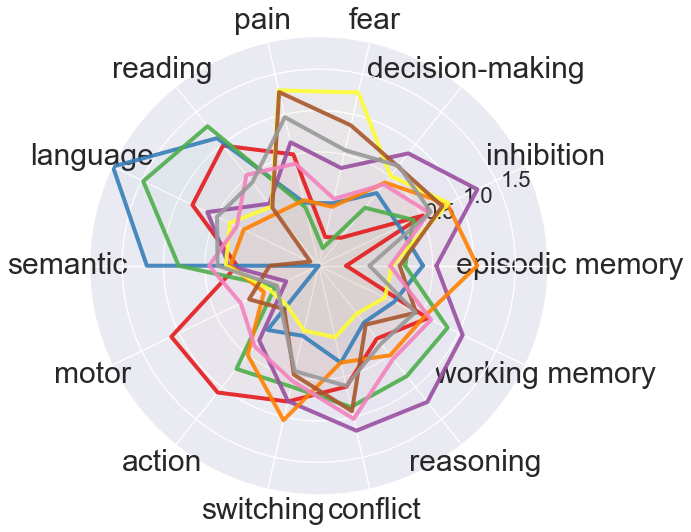

In [157]:
all_labels = plot_clf_polar(o_clf, n_top=2, cmap=core_colors, return_labels=True)

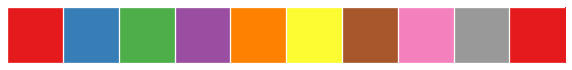

In [140]:
sns.palplot(sns.color_palette('Set1', 10))

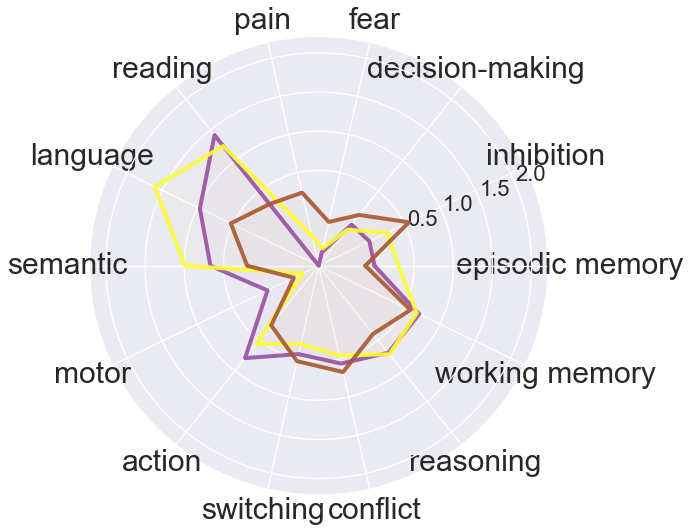

In [164]:
colors = (sns.color_palette('Set1', 10)[3],sns.color_palette('Set1', 10)[5],sns.color_palette('Set1', 10)[6])
mask = range(5, 7)
plot_clf_polar(o_clf, mask=[5, 6, 7], labels=all_labels, cmap=colors, max_val=2.2)

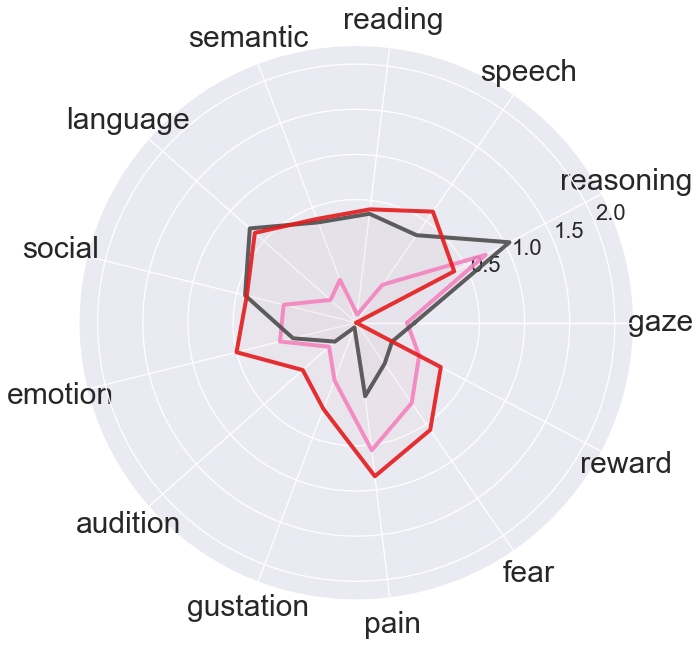

In [182]:
colors = (sns.color_palette('Set1', 10)[7], (.3, .3, .3), sns.color_palette('Set1', 10)[9])
mask = range(8, 11)
plot_clf_polar(o_clf, mask=mask, selection='std', n_top=13, cmap=colors, max_val=2.2)

(0.60000002384185791, 0.60000002384185791, 0.60000002384185791)

In [168]:
colors

[(0.60000002384185791, 0.60000002384185791, 0.60000002384185791),
 (0.89411765336990356, 0.10196078568696976, 0.10980392247438431)]

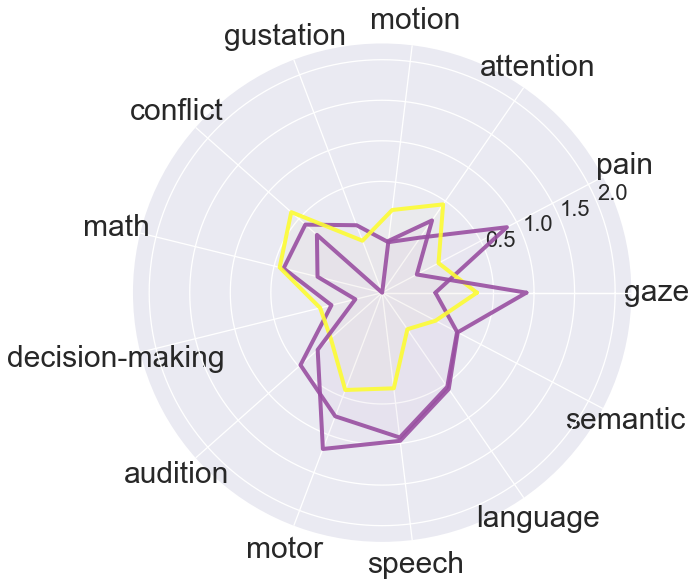

In [147]:
colors = (sns.color_palette('Set1', 10)[3],sns.color_palette('Set1', 10)[5])
mask = range(5, 7)
plot_clf_polar(o_clf, mask=[1, 2, 3], selection='std', n_top=13, cmap=colors, max_val=2.2)

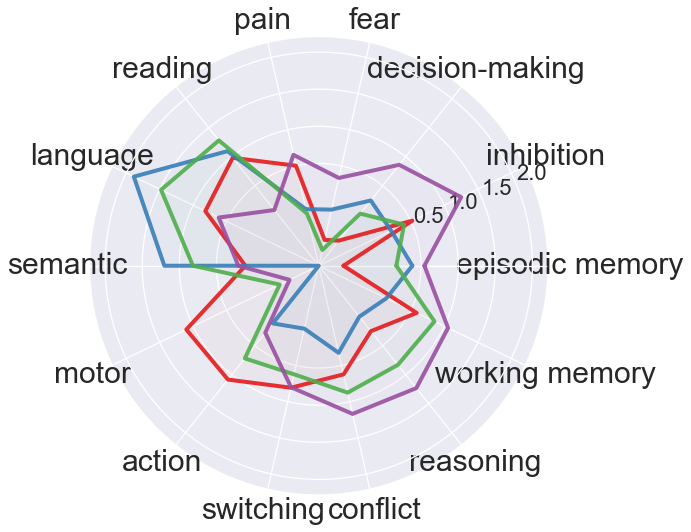

In [159]:
colors = sns.color_palette('Set1', 4)
plot_clf_polar(o_clf, mask=[1, 2, 3, 4], labels=all_labels, cmap=colors, max_val=2.2)

In [132]:
colors

(1.0,
 0.50591311045721465,
 0.0031372549487095253,
 0.65845446095747107,
 0.34122261685483596,
 0.1707958535236471)

In [ ]:
plot_

In [87]:
range(5,8),

(1, 2, 3)

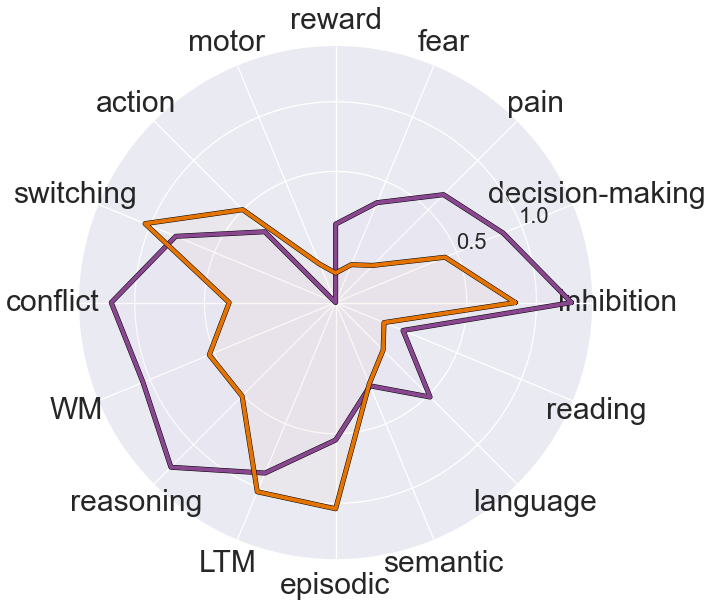

In [310]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in LPFCPar])
plot_clf_polar(o_clf, mask=mask, labels=all_labels, cmap=colors, max_val=1.4)

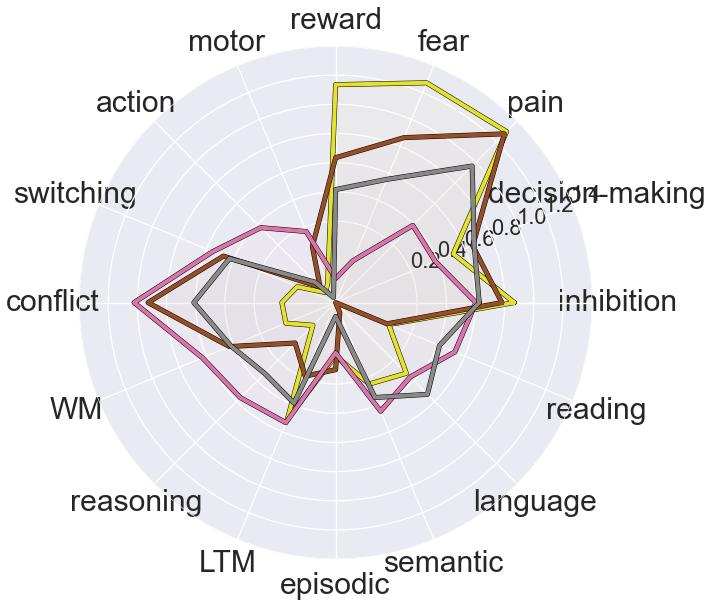

In [311]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in CON])
plot_clf_polar(o_clf, mask=mask, labels=all_labels, cmap=colors, max_val=1.4)

### STD

In [121]:
all_labels_std = plot_clf_polar(clf, cmap=core_colors, return_labels=True, selection='std', n_top=14)

AttributeError: 'str' object has no attribute 'odds_ratio'

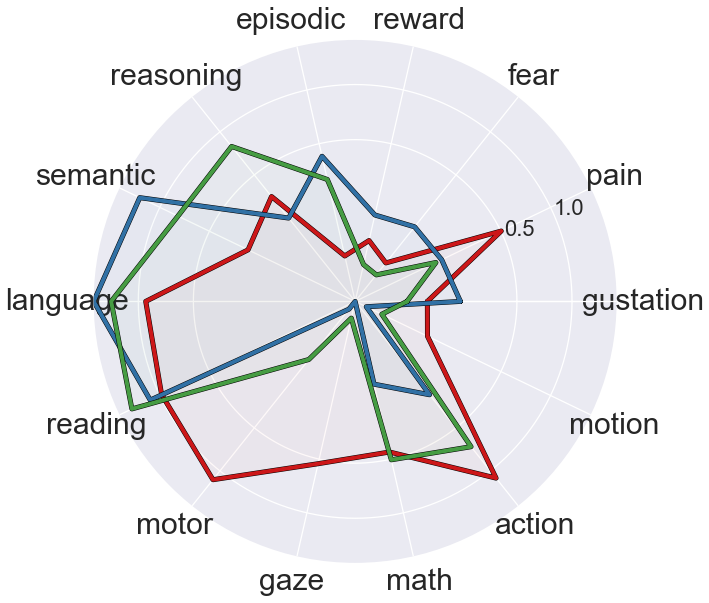

In [59]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in preMIFJ])
plot_clf_polar(clf, mask=mask, labels=all_labels_std, cmap=colors)

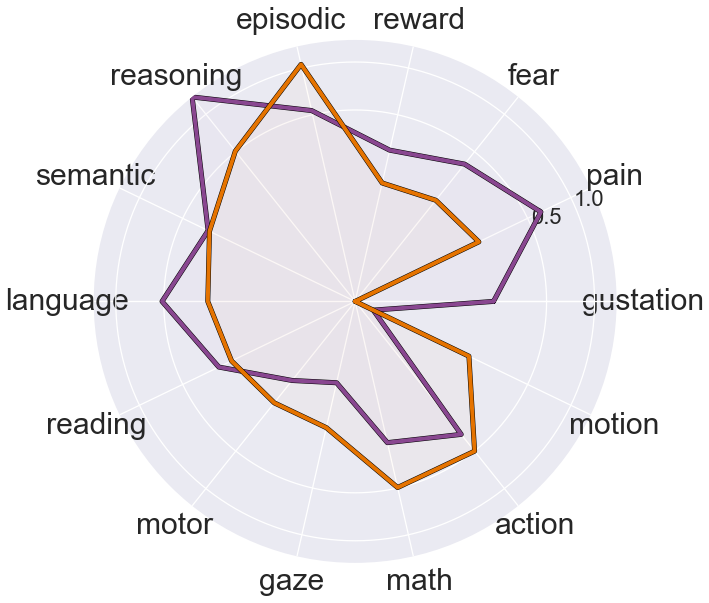

In [60]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in LPFCPar])
plot_clf_polar(clf, mask=mask, labels=all_labels_std, cmap=colors)

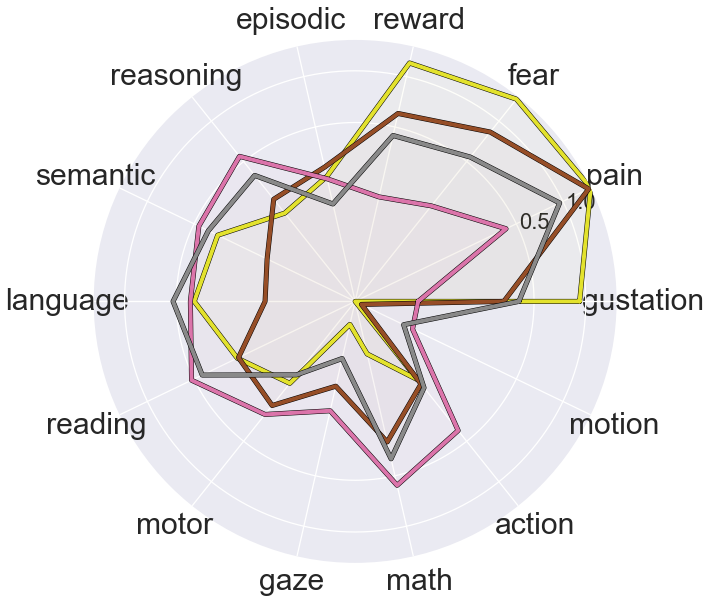

In [61]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in CON])
plot_clf_polar(clf, mask=mask, labels=all_labels_std, cmap=colors)

### Coactivation maps

In [312]:
def make_thresholded_axials(init_path, regions, colors, stat="pFgA_z_FDR_0.01", overplot=True, threshold=True, **kwargs):
    import os
    from nilearn import plotting as plt
    import matplotlib.pyplot as mlplt
    
    reg_nibs = [nib.load(os.path.join(init_path, "cluster_" + str(reg) + "_" + stat + ".nii.gz")) for reg in regions]                   
                
    if threshold:
        # Threshold
        for reg in reg_nibs:
             reg.get_data()[reg.get_data().nonzero()] = 1
                                   
    for i, reg in enumerate(reg_nibs):
        reg_color = ml.colors.LinearSegmentedColormap.from_list('reg1', [colors[i], colors[i]])
        if i == 0:
            plot = plt.plot_stat_map(reg, draw_cross=False,  display_mode='z', cmap = reg_color, alpha=0.9, colorbar=False, **kwargs)
        else:
            if overplot:
                plot.add_overlay(reg, cmap = reg_color, alpha=.72)
            else:
                plt.plot_stat_map(reg, draw_cross=False,  display_mode='z', cmap = reg_color, colorbar=False, **kwargs)
    
    return plot
                      

In [296]:
def mask_level(path, level):
    img = nib.load(path)
    data = img.get_data()
    data[:] = np.round(data)
    data[data != level] = 0 
    data[data == level] = 1
    
    return img

import neurosynth.analysis.meta as meta
outdir = '../results/clustering/results/LFC/kmeans_k23/coactivation_al'
mFC_file = '../results/clustering/results/LFC/kmeans_k23/cluster_labels.nii.gz'

colors, region_set = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in coreB])

for c in region_set:
    other_ids = [dataset.get_studies(mask=mask_level(mFC_file, a), activation_threshold=0.01)
                     for a in region_set if a != c]
    joined_ids = set()
    for ids in other_ids:
        joined_ids = joined_ids | set(ids)
        
        
    reg_ids = dataset.get_studies(mask=mask_level(mFC_file, c), activation_threshold=0.03)
    ma = meta.MetaAnalysis(dataset, reg_ids, ids2=list(joined_ids))
    ma.save_results(outdir, 'cluster_%d' % c)

In [310]:
colors

((0.89411765336990356, 0.10196078568696976, 0.10980392247438431),
 (0.99315647868549117, 0.9870049982678657, 0.19915417450315812))

In [347]:
cut_coords = np.arange(-18, 60, 12)

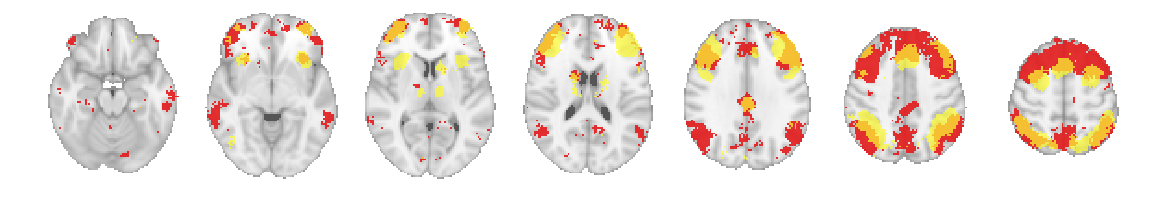

In [348]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in coreB])

make_thresholded_axials('../results/clustering/results/LFC/kmeans_k23/coactivation_al', mask, colors, 
                        annotate=False, cut_coords=cut_coords)
# mlplt.savefig('../reports/papers/mFC/3_parcels_ri_coactivation.png',bbox_inches='tight')

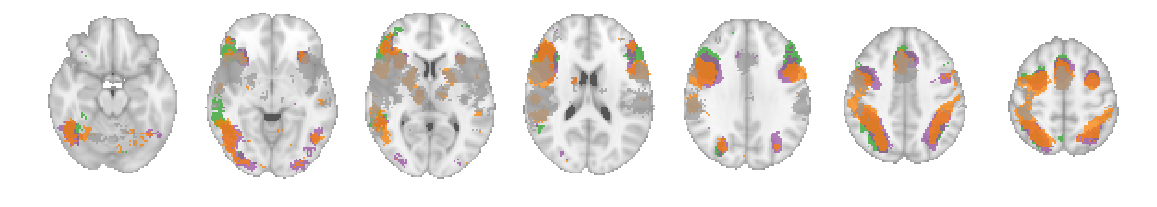

In [349]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in coreL])

make_thresholded_axials('../results/clustering/results/LFC/kmeans_k23/coactivation_al', mask, colors, 
                        annotate=False, cut_coords=cut_coords)
# mlplt.savefig('../reports/papers/mFC/3_parcels_ri_coactivation.png',bbox_inches='tight')

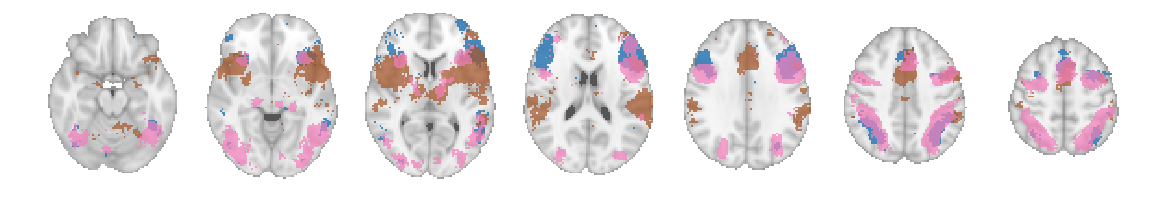

In [350]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in coreR])

make_thresholded_axials('../results/clustering/results/LFC/kmeans_k23/coactivation_al', mask, colors, 
                       annotate=False, cut_coords=cut_coords)
# mlplt.savefig('../reports/papers/mFC/3_parcels_ri_coactivation.png',bbox_inches='tight')

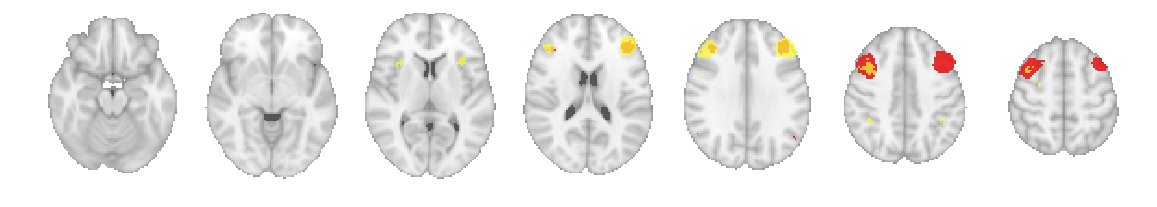

In [351]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in coreB])

make_thresholded_axials('../results/clustering/results/LFC/kmeans_k23/coactivation', mask, colors, 
                        annotate=False, cut_coords=cut_coords)
# mlplt.savefig('../reports/papers/mFC/3_parcels_ri_coactivation.png',bbox_inches='tight')

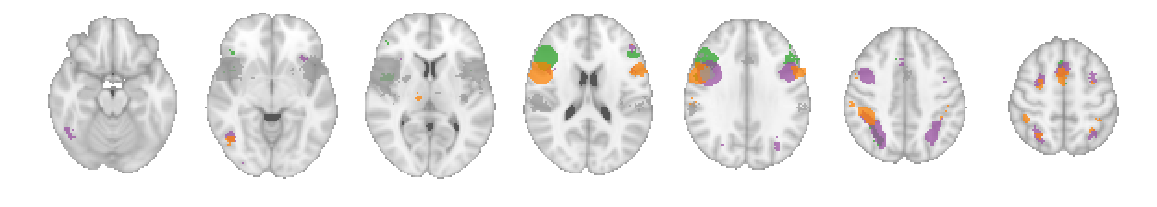

In [352]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in coreL])

make_thresholded_axials('../results/clustering/results/LFC/kmeans_k23/coactivation', mask, colors, 
                        annotate=False, cut_coords=cut_coords)
# mlplt.savefig('../reports/papers/mFC/3_parcels_ri_coactivation.png',bbox_inches='tight')

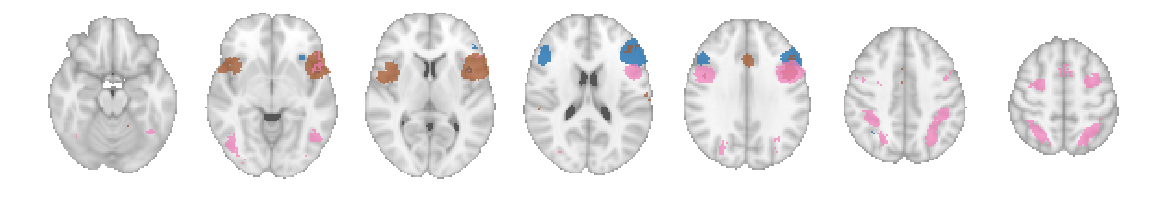

In [353]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in coreR])

make_thresholded_axials('../results/clustering/results/LFC/kmeans_k23/coactivation', mask, colors, 
                       annotate=False, cut_coords=cut_coords)
# mlplt.savefig('../reports/papers/mFC/3_parcels_ri_coactivation.png',bbox_inches='tight')

## Pairwise

In [4]:
pair_clfs = [OnevsallClassifier.load(clf + "/classifier.pkl") for clf in glob.glob("../results/classification/fpn_hier*9*Pairwise*Ridge*/")]

NameError: name 'glob' is not defined

In [2]:
from scipy.stats import pearsonr

In [3]:
pearsonr(pair_clfs[0].class_score, pair_clfs[1].class_score)

NameError: name 'pair_clfs' is not defined

In [136]:
p_clf.feature_importances.max()

0.23119369964657441

In [17]:
p_clf.feature_importances.min()

-0.23119369964657388

In [18]:
p_clf.feature_importances.mean()

-1.9812060708799089e-17

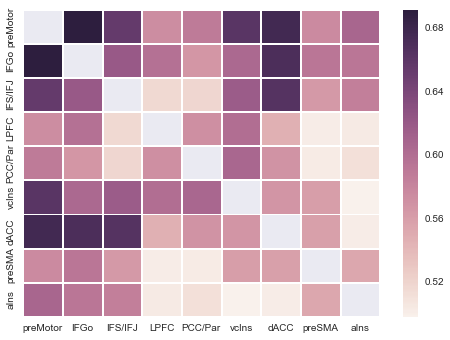

In [23]:
sns.heatmap(p_clf.class_score, mask=p_clf.class_score.mask, vmin=p_clf.class_score.min(), xticklabels=core_regionsAll.keys(), yticklabels=core_regionsAll.keys())

## Functional differences

In [91]:
from base.plotting import plot_polar

In [76]:
p_fi = []
for i, a in enumerate(p_clf.feature_importances):
    for j, b in enumerate(a):
        if i != j:
            p_fi.append(pd.DataFrame(
                    {'region_a' : np.repeat(j+1, 33), 'region_b' : np.repeat(i+1, 33) , 'topic_name' : p_clf.feature_names, 'importance' :b}))

p_fi = pd.concat(p_fi)
p_fi = pd.merge(p_fi, word_keys)

In [114]:
def plot_pclf_polar(p_fi, region_a, regions_b=None, cmap=None, **kwargs):
    p_fi = p_fi[p_fi.region_a == region_a]
    
    if regions_b is not None:
        p_fi = p_fi[p_fi.region_b.isin(regions_b)]
        
    pplot = pd.pivot_table(p_fi, values='importance', index=['nickname'], columns=['region_b'])
    pplot[pplot < 0] = 0
    
    if cmap is None:
        cmap = sns.color_palette('Set1', p_fi.region_b.unique().shape[0])

    return plot_polar(pplot, overplot=True, palette=cmap, **kwargs)

In [111]:
def pclf_polar_two(p_fi, region_a, region_b, colors, **kwargs):
    p_fi = p_fi[((p_fi.region_a == region_a) & (p_fi.region_b == region_b)) | ((p_fi.region_a == region_b) & (p_fi.region_b == region_a)) ]
    pplot = pd.pivot_table(p_fi, values='importance', index=['nickname'], columns=['region_a'])
    
    pplot[pplot < 0] = 0
    cmap = [color for i, color in enumerate(colors) if i+1 in pplot.columns]
    
    return plot_polar(pplot, overplot=True, palette=cmap, **kwargs)

In [1]:
core_colors

NameError: name 'core_colors' is not defined

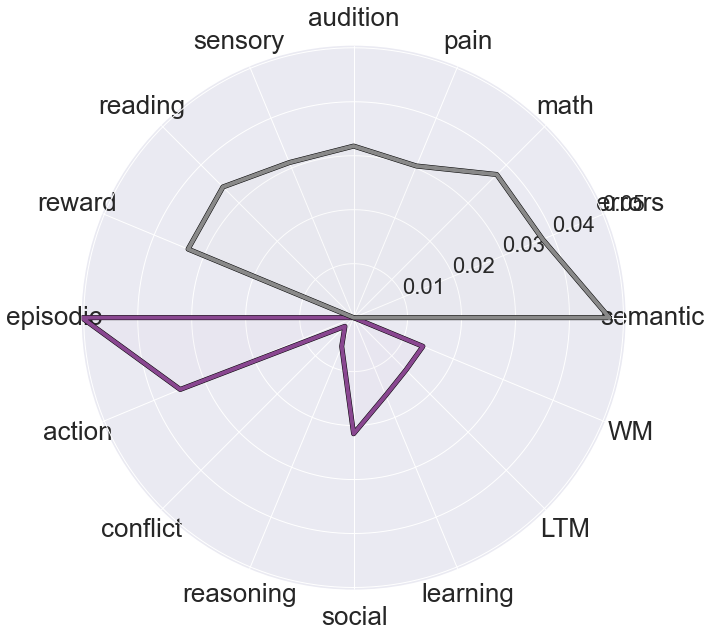

In [115]:
pclf_polar_two(p_fi, 4, 9, core_colors, n_top=8)

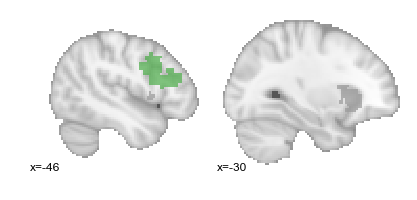

In [33]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in ['IFS/IFJ', 'aIns']])

plot_subset('../results/clustering/hierarchical/fastward_FPN_min120/cluster_labels_k9.nii.gz', mask, colors=colors, 
            display_mode='x', cut_coords=[-46,  -30])


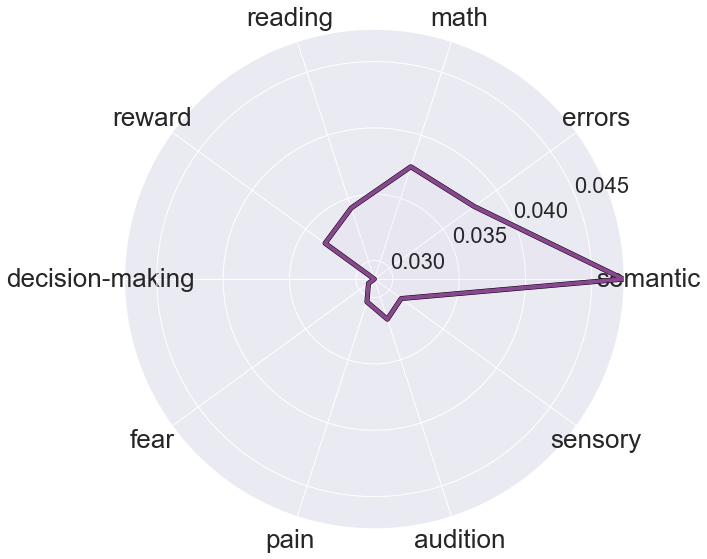

In [50]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in ['LPFC']])
plot_pclf_polar(p_fi, 9, mask, n_top=10, cmap=colors)

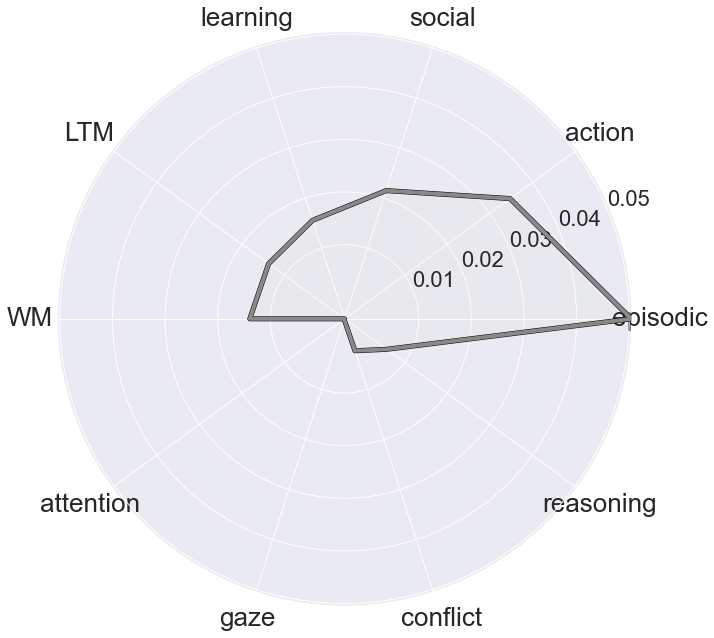

In [49]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in ['aIns']])
plot_pclf_polar(p_fi, 4, mask, n_top=10, cmap=colors)

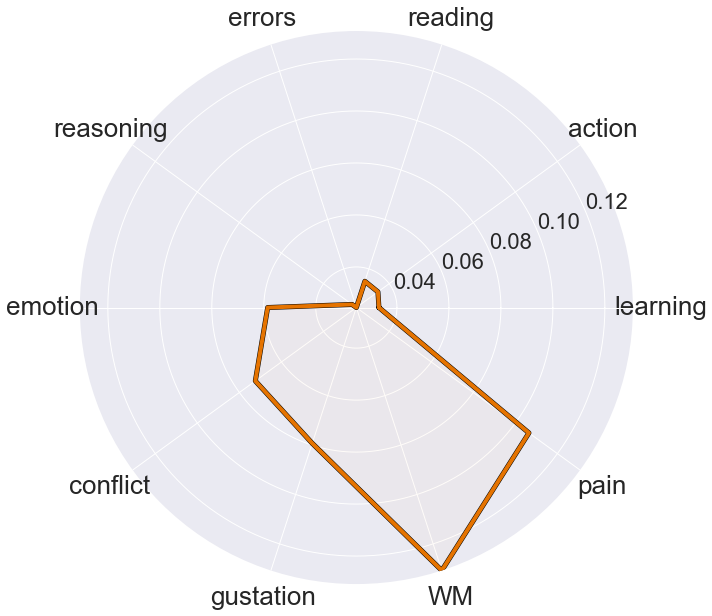

In [51]:
colors, mask = zip(*[(core_colors[i], v) for i, (k, v) in enumerate(core_regionsAll.iteritems()) if k in ['PCC/Par']])
plot_pclf_polar(p_fi, 4, mask, n_top=10, cmap=colors)

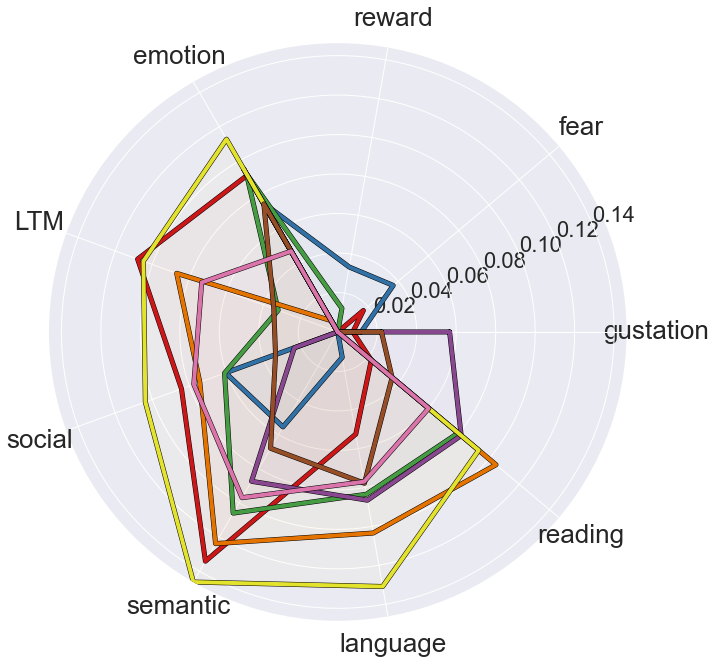

In [117]:
plot_pclf_polar(p_fi, 2, n_top=5)

In [ ]:
plot_pclf_polar(p_fi, 2, n_top=5)

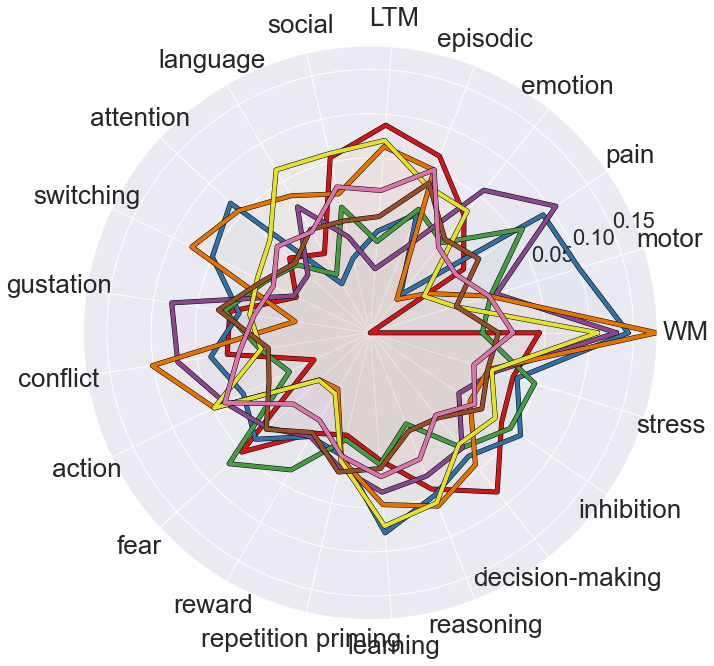

In [47]:
plot_pclf_polar(p_fi, 4, n_top=5)

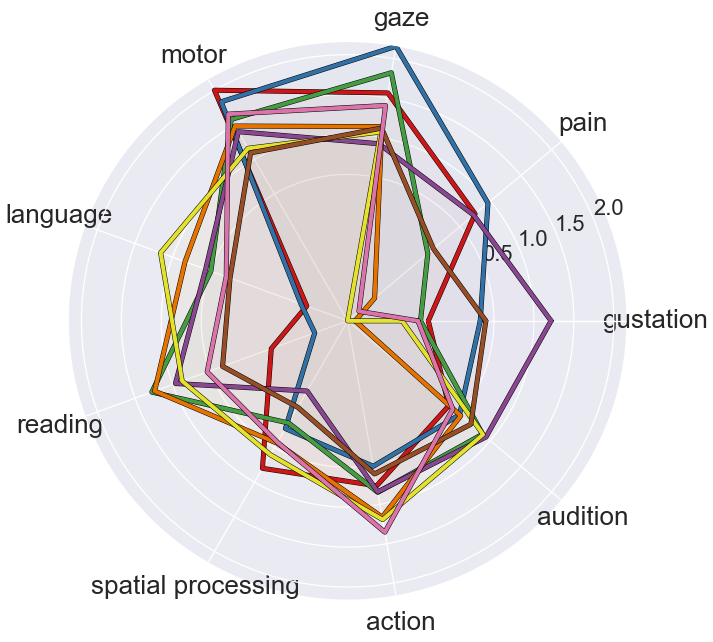

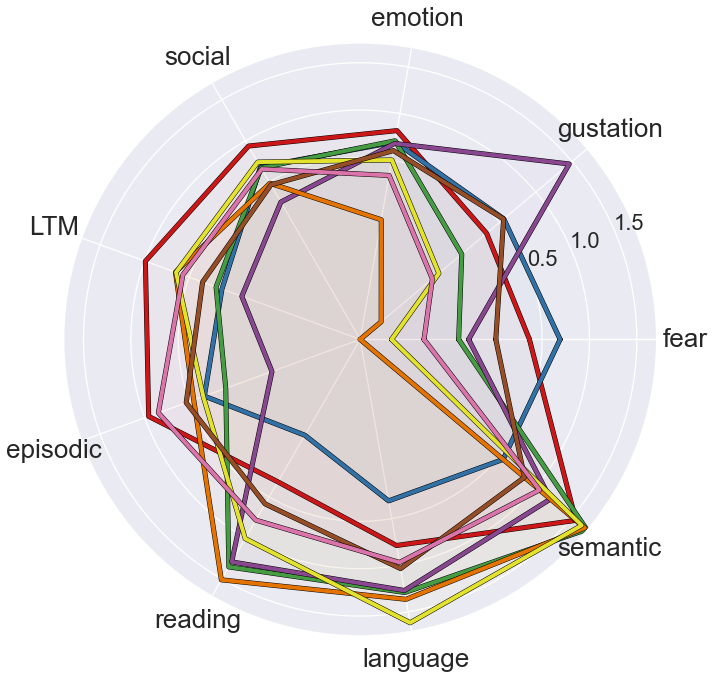

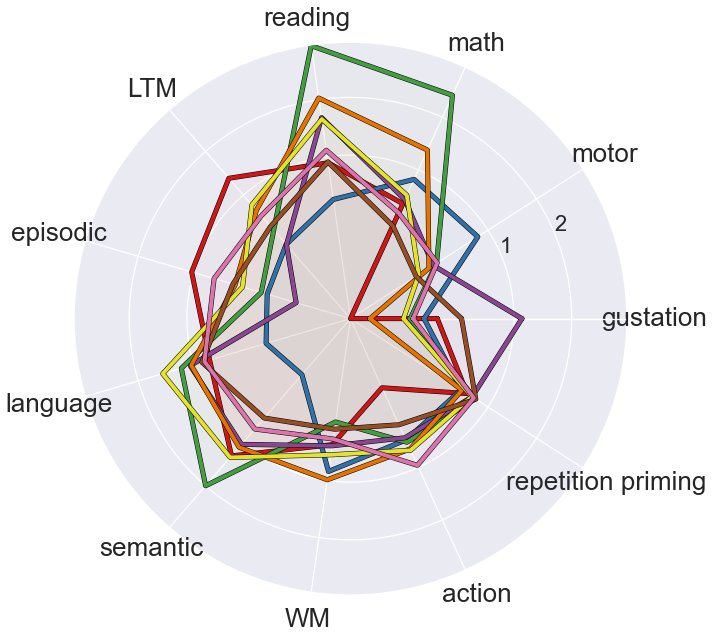

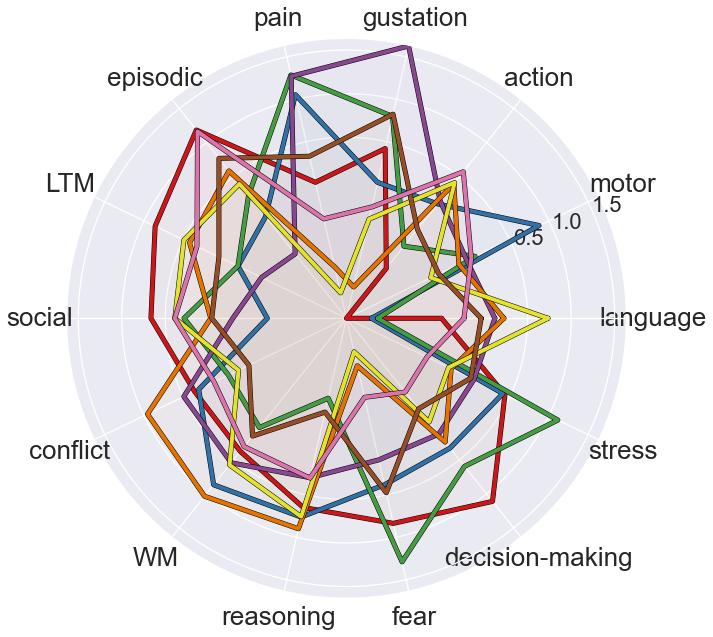

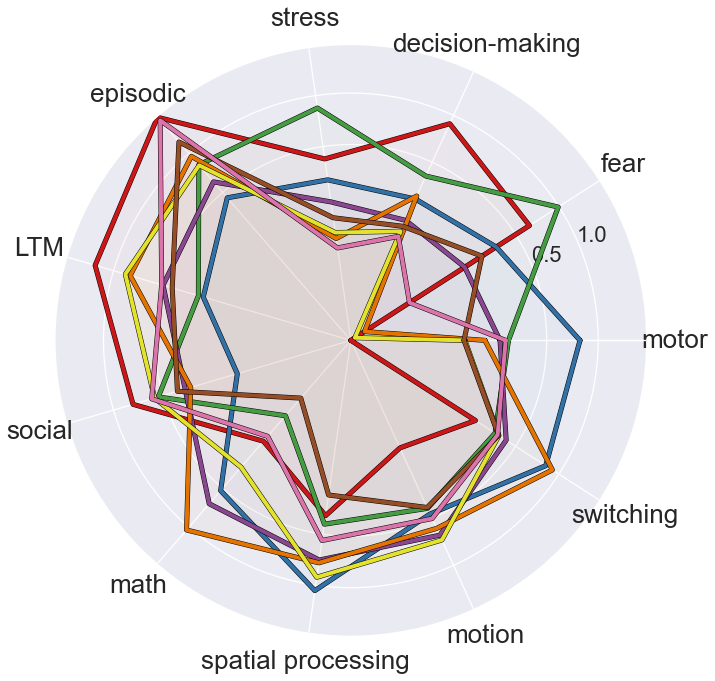

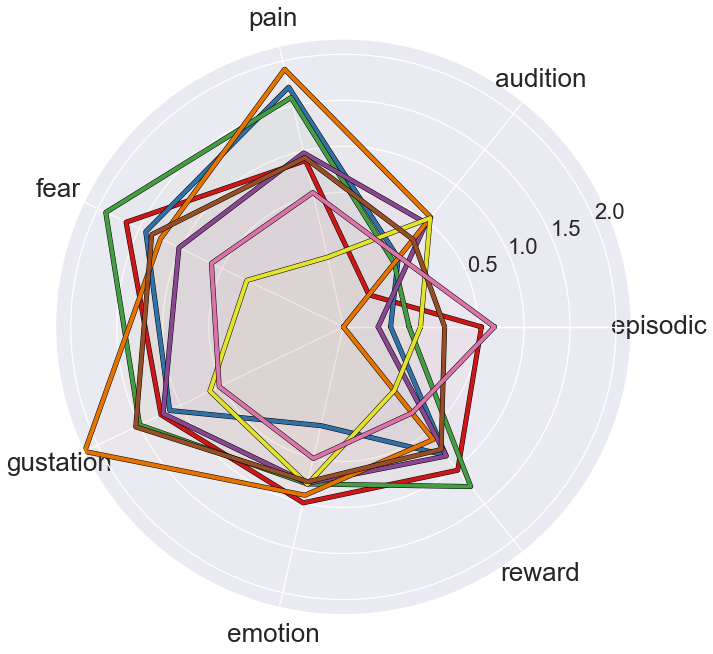

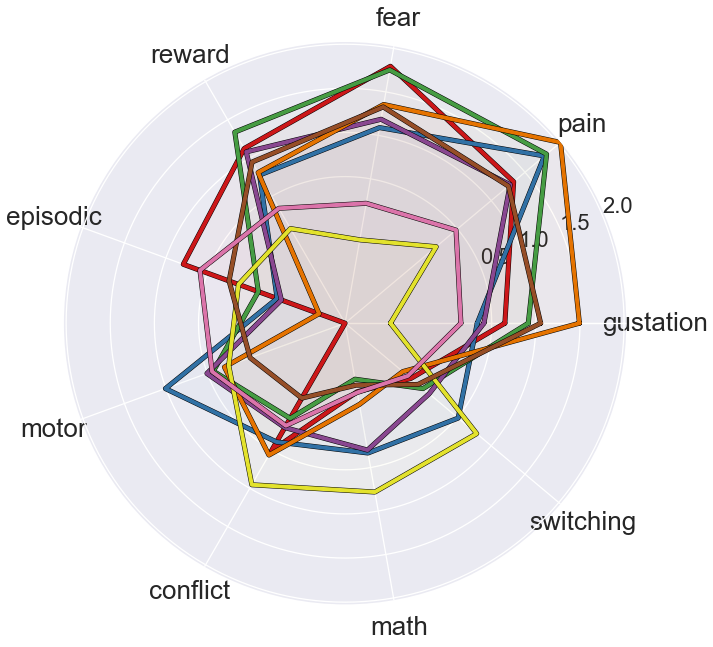

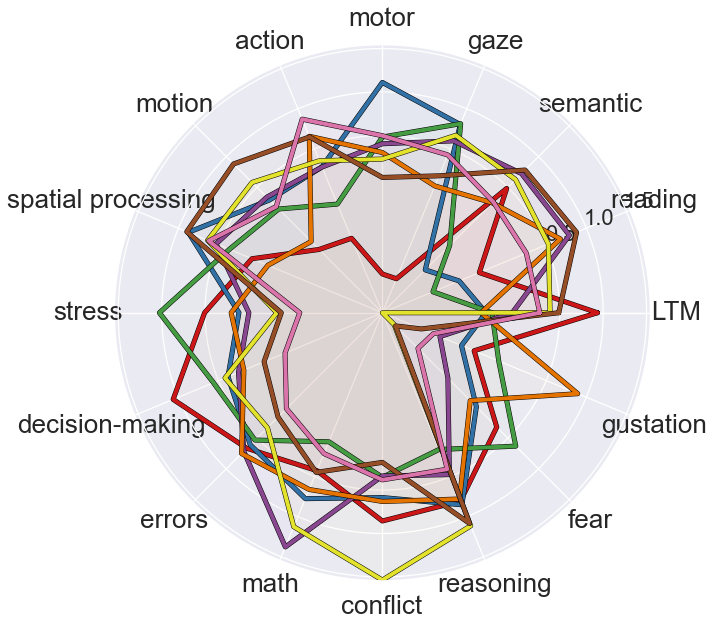

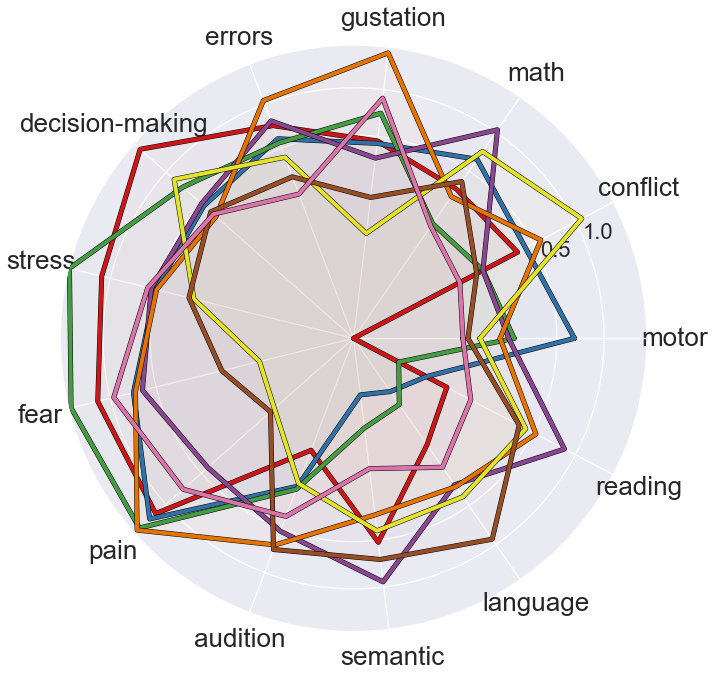

In [277]:
for i in range(1, 10):
    plot_pclf_polar(p_fi, i,)

### Co-activation distance

In [210]:
avg_act = []
for reg in p_clf.ids_by_masks:
    avg = dataset.get_image_data(reg).mean(axis=1)
    avg_act.append(avg)

In [211]:
avg_act = np.vstack(avg_act)

In [408]:
pw = pairwise_distances(avg_act)
from base.tools import mask_diagonal
pw = mask_diagonal(np.ma.masked_array(pw))

In [409]:
pw_df = pd.DataFrame(pw).stack().reset_index().rename(columns={'level_0' : 'region_a', 'level_1' : 'region_b', 0 : 'coactivation_distance'})

In [410]:
cs_df = pd.DataFrame(p_clf.class_score).stack().reset_index().rename(columns={'level_0' : 'region_a', 'level_1' : 'region_b', 0 : 'class_score'})

In [411]:
coact_feature_dist = pd.merge(pw_df, cs_df)

In [412]:
coact_feature_dist.corr()

region_a  region_b  coactivation_distance  class_score
region_a               1.000000 -0.125000              -0.209693    -0.399364
region_b              -0.125000  1.000000              -0.209693    -0.399364
coactivation_distance -0.209693 -0.209693               1.000000    -0.014540
class_score           -0.399364 -0.399364              -0.014540     1.000000

In [413]:
coact_feature_dist['pair'] = coact_feature_dist.region_a.astype('str') + "," + coact_feature_dist.region_b.astype('str')

In [414]:
mpld3.enable_notebook()

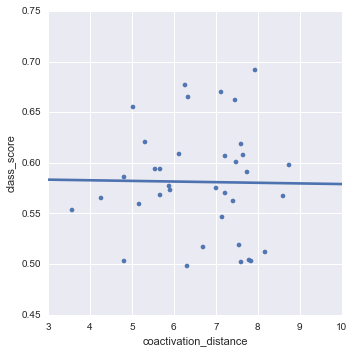

In [415]:
coact_cs_plot = sns.lmplot('coactivation_distance', 'class_score', coact_feature_dist, ci=None)
tooltip = mpld3.plugins.PointLabelTooltip(coact_cs_plot.axes[0][0].collections[0], labels=list(coact_feature_dist.pair))
fig = plt.gcf()
mpld3.plugins.connect(fig, tooltip)